In [11]:
%matplotlib inline
from sensor_data_analysis_api import *
from sklearn.metrics import mean_squared_error
import sys
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

blockPrint()

In [3]:
room = 'Rm-4226'
signals = ['Zone Temperature']
method = 'piecewise_constant'

df_4226_zt = get_signal_dataframe(room, signals, mean_type=None, use_weather_data=False)
df_4226_all = get_signal_dataframe(room, mean_type="quarter_hour" , use_weather_data=False)

### Calculate the root mean squared error and compression ratio for piecewise linear and piece constant

**Compression calculation for piecewise linear and piecewise constant**

- original_size = Filter the data frame for specific week and find the **memory usage** of the data frame (DataFrame.memory_usage())
- compressed_size = Calculate the compressed size with **memory_usage()** on compressed DataFrame
- compression_ratio is calculated as
$$
compression\_ratio = \frac{(original\_size - compressed\_size)}{original\_size}
$$
- Good compression has compression_ratio close to 1.


In [4]:
stTime = pd.to_datetime('2014-01-01')
enTime = stTime + pd.to_timedelta("7 days")
df_list = []
for signal in signals:
    while enTime <= pd.to_datetime('2015-12-31'):
        
        print "********* ", enTime, "********* "

        # piece wise linear
        method = 'piecewise_linear'
        [dfs, plotTemplates, dfs_compressed] = runAnalysis(df_4226_zt, stTime, enTime, templates = [signal], method = method)
        rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
        d = {
             'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
             'original_size' : dfs[0].memory_usage().sum() - dfs[0].memory_usage()['Index'],
             'compressed_size' : dfs_compressed[0].memory_usage().sum() - dfs_compressed[0].memory_usage()['Index']
            }
        df_list.append(pd.DataFrame(d, index=[0]))

        # piecewise constant
        method = 'piecewise_constant'
        [dfs, plotTemplates, dfs_compressed] = runAnalysis(df_4226_zt, stTime, enTime, templates = [signal], method = method)
        rmse = mean_squared_error(dfs[0]['values'][dfs[1].notnull()], dfs[1][dfs[1].notnull()])
        d = {
             'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
             'original_size' : dfs[0].memory_usage().sum() - dfs[0].memory_usage()['Index'],
             'compressed_size' : dfs_compressed[0].memory_usage().sum() - dfs_compressed[0].memory_usage()['Index']
            }
        df_list.append(pd.DataFrame(d, index=[0]))

        # run length encoding
        method = "run_length_encoding"
        [dfs1, plotTemplates, dfs_compressed] = run_length_encoding(df_4226_zt[['time',  'Zone Temperature']],
                   stTime=stTime, enTime=enTime,
                   tolerance = [pd.to_timedelta("15 minutes"), 1])
        rmse = mean_squared_error(dfs1[0]['values'][dfs1[1].notnull()], dfs1[1][dfs1[1].notnull()])
        d = {
             'room' : room, 'model' : method, 'rmse' : rmse, 'signal' : signal, 'start_time' : stTime, 'end_time' : enTime,
             'original_size' : dfs1[0].memory_usage().sum() - dfs1[0].memory_usage()['Index'],
             'compressed_size' : dfs_compressed[0].memory_usage().sum() - dfs_compressed[0].memory_usage()['Index']
            }
        df_list.append(pd.DataFrame(d, index=[0]))

        # increase by 1 week
        stTime = stTime + pd.to_timedelta("7 days")
        enTime = stTime + pd.to_timedelta("7 days")

### Compression and encoding with PCA

**encoding and compression**

- One signal for all the dates (weeks) for few rooms are taken.
- Values are averaged for every 15 minute interval. (This is needed because the signals are not recorded exactly at the same time for all signals). so we have to average them for every 15 minutes to bring them to a common scale.
- This is the original data frame and its size is calculated using **memory_usage** function
- PCA is performed on this dataframe and only top n components are choosen
- vectors: zone temperature values accross the week for every 15 minutes is the vector. 672 signals per week are recorded.
- Samples: each week is treated as a sample.
- **compressed_size** if the size of the transformed data with top n components.
- compression_ratio is calculated as
$$
compression\_ratio = \frac{(original\_size - compressed\_size)}{original\_size}
$$
- Good compression has compression_ratio close to 1.
- For PCA the compression ratio do not depend on dates and signal type because complete dataframe with all signals and all dates are used for transformation.
- For PCA compression ratio only depends on number of components chosen.

In [38]:
rooms = ['Rm-2221', 'Rm-3126', 'Rm-2218', 'Rm-3122', 'Rm-3111','RM-1217', 'Rm-2226', 'Rm-3118', 'RM-1231', 'Rm-2230','RM-1229', 'Rm-2232']
signals=['Zone Temperature']
pivotDF= pd.DataFrame()
for r in rooms:
    dataDF = get_signal_dataframe(room=r,signals=signals,mean_type="quarter_hour" , use_weather_data=False).dropna()
    for yr in dataDF.time.dt.year.unique():
        dataDFr = dataDF[dataDF.time.dt.year==yr]
        dataDFr['week#'] = dataDFr.time.dt.week
        dataDFr['year#'] = dataDFr.time.dt.year
        dataDFr['yearweek'] = dataDFr['year#'].astype(str)+dataDFr['week#'].astype(str)
        dataDFr['week'] = 'week'+dataDFr.time.dt.week.astype(str)
        dataDFr['timeofday'] = dataDFr.time.dt.time
        dataDFr['dayofweek'] = dataDFr.time.dt.dayofweek
        dataDFr = dataDFr[~(dataDFr['week#'].isin([1,52,53]))]
        df = dataDFr[['yearweek','week#','week',signals[0],'time','dayofweek','timeofday']]
        df['daytime'] = 'day'+df['dayofweek'].astype(str)+':'+df['timeofday'].astype(str)
        pivotDF=pivotDF.append(df.pivot(index=('yearweek'), columns='daytime', values=signals[0]).dropna().reset_index())

### Number of PCA components

- Number of components Vs explained variance is plotted
- 95% of variance is explained with 10 components.

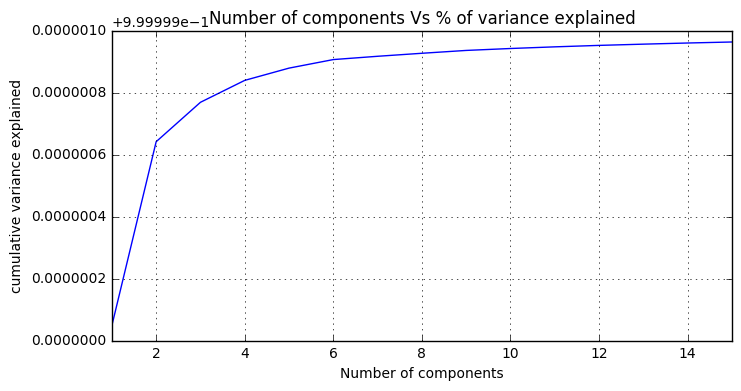

In [39]:
n_components = len(pivotDF.columns)
pca = PCA(n_components = n_components).fit(pivotDF)
top_components = 15
ax = pd.Series(np.cumsum(pca.explained_variance_ratio_[:top_components]), index=range(1, top_components + 1)).plot(
    grid=True, title='Number of components Vs % of variance explained', figsize=(8, 4))
ax.set(xlabel='Number of components', ylabel='cumulative variance explained');

In [50]:
for n_components in [5, 10, 15, 20]:
    pca = PCA(n_components = n_components).fit(pivotDF)
    transformed = pca.transform(pivotDF)
    recon = pca.inverse_transform(transformed)

    for i in range(50):
        rmse = mean_squared_error(pivotDF.iloc[i, :], recon[i, :])
        d = {
             'model' : "PCA_%d"%n_components, 'rmse' : rmse, 'signal' : 'Zone Temperature',
             'original_size' : pivotDF.memory_usage().sum() - pivotDF.memory_usage()['Index'],
             'compressed_size' : transformed.nbytes
            }
        df_list.append(pd.DataFrame(d, index=[0]))

### Comparitive analysis Results.

- Piece wise constant and PCA with 15 components give the optimal models for rmse vs compression ratio
- The variance in RMSC for run length encoding is very less compared to other methods. however the compression ratio has high variance.
- compression ratio for PCA do not depend on week. it depends on number of top components chosen.
- PCA is effective when compare to others.
- piece wise linear gives the least compression ratio with most RMSE.
- with PCA 20 components compression ratio has reduced but without signification reduction in RMSE.

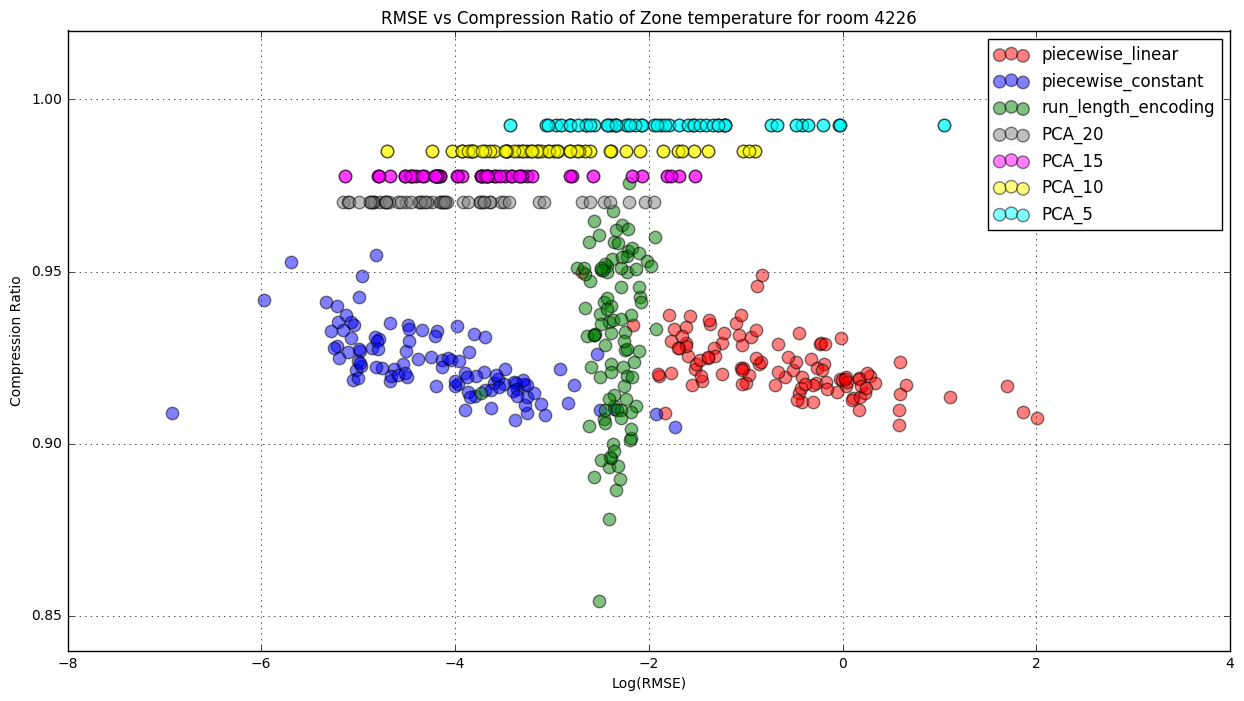

In [51]:
df_result = pd.concat(df_list, ignore_index=True)
df_result['compression_ratio'] = (df_result.original_size - df_result.compressed_size) / df_result.original_size
df_result['rmse_log'] = np.log2(df_result.rmse)
df_result = df_result[df_result.compression_ratio > 0.85]

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(x = df_result[df_result.model == 'piecewise_linear'].rmse_log,
          y = df_result[df_result.model == 'piecewise_linear'].compression_ratio,
          c = 'red', s=80,
          label='piecewise_linear', alpha=0.5);
ax.scatter(x = df_result[df_result.model == 'piecewise_constant'].rmse_log,
          y = df_result[df_result.model == 'piecewise_constant'].compression_ratio,
          c = 'blue', s=80,
          label='piecewise_constant', alpha=0.5);
ax.scatter(x = df_result[df_result.model == 'run_length_encoding'].rmse_log,
          y = df_result[df_result.model == 'run_length_encoding'].compression_ratio,
          c = 'green', s=80,
          label='run_length_encoding', alpha=0.5);
ax.scatter(x = df_result[df_result.model == 'PCA_20'].rmse_log,
          y = df_result[df_result.model == 'PCA_20'].compression_ratio,
          c = 'gray', s=80,
          label='PCA_20', alpha=0.5);
ax.scatter(x = df_result[df_result.model == 'PCA_15'].rmse_log,
          y = df_result[df_result.model == 'PCA_15'].compression_ratio,
          c = 'magenta', s=80,
          label='PCA_15', alpha=0.5);
ax.scatter(x = df_result[df_result.model == 'PCA_10'].rmse_log,
          y = df_result[df_result.model == 'PCA_10'].compression_ratio,
          c = 'yellow', s=80,
          label='PCA_10', alpha=0.5);
ax.scatter(x = df_result[df_result.model == 'PCA_5'].rmse_log,
          y = df_result[df_result.model == 'PCA_5'].compression_ratio,
          c = 'cyan', s=80,
          label='PCA_5', alpha=0.5);
ax.legend(loc='best')
ax.grid(True)
ax.set_xlabel("Log(RMSE)")
ax.set_ylabel("Compression Ratio")
ax.set_title("RMSE vs Compression Ratio of Zone temperature for room 4226");